In [2]:
import h5py
import numpy as np
import scipy.io
from keras.utils.io_utils import HDF5Matrix
import matplotlib.pyplot as plt

E:\program\Anaconda3\envs\tensorflow_gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Instantiating HDF5Matrix for the training set, which is a slice of the first 150 elements
filename = 'croped_seg.mat'
X_train = HDF5Matrix(filename, 'images', start=0, end=130)
y_train = HDF5Matrix(filename, 'labels', start=0, end=130)

y_train = np.expand_dims(np.asarray(y_train), axis = 3)

# Likewise for the test set
X_test = HDF5Matrix(filename, 'images', start=130, end=140)
y_test = HDF5Matrix(filename, 'labels', start=130, end=140)
#X_test = X_test.resize([X_test.shape[0],224,224,3])

y_test = np.expand_dims(np.asarray(y_test), axis = 3)
print(y_train.shape)
print(X_train.shape)

(130, 112, 112, 1)
(130, 224, 224, 3)


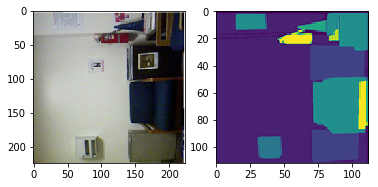

In [4]:
plt.figure(1)
plt.subplot(121)
plt.imshow(X_train[2])

plt.subplot(122)
plt.imshow(y_train[2][:,:,0])
plt.show()

In [6]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import SGD
from keras import backend as K
from PIL import Image
import keras
import tensorflow as tf

In [7]:
# create the base pre-trained model
# inceptionV3 default input 299*299
#base_model = InceptionV3(weights='imagenet', include_top=False)
base_model = ResNet50(weights='imagenet')

In [110]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [8]:
def up_pool(x, fil, relu=True):
    outputA = keras.layers.Conv2D(filters = fil, kernel_size= 3, padding = 'same',kernel_initializer = 'random_normal',
                                     bias_initializer = 'random_normal',strides= 1 , activation = 'linear')(x)
    outputB = keras.layers.Conv2D(filters = fil, kernel_size= 3, padding = 'same',kernel_initializer = 'random_normal',
                                     bias_initializer = 'random_normal',strides= 1 , activation = 'linear')(x)
    outputC = keras.layers.Conv2D(filters = fil, kernel_size= 3, padding = 'same',kernel_initializer = 'random_normal',
                                     bias_initializer = 'random_normal',strides= 1 , activation = 'linear')(x)
    outputD = keras.layers.Conv2D(filters = fil, kernel_size= 3, padding = 'same',kernel_initializer = 'random_normal',
                                     bias_initializer = 'random_normal',strides= 1 , activation = 'linear')(x)
    
    left = keras.layers.Concatenate(axis=1)([outputA, outputB])
    right = keras.layers.Concatenate(axis=1)([outputC, outputD])
    Y = keras.layers.Concatenate(axis=2)([left, right])
    Y = keras.layers.BatchNormalization()(Y)
    if relu:
        Y = keras.layers.Activation('relu')(Y)
    
    return Y

In [9]:
def up_sampleo(x, fil):
    x1 = up_pool(x, fil)
    x2 = up_pool(x, fil,False)
    x1 = keras.layers.BatchNormalization()(x1)
    x = keras.layers.Add()([x1, x2])
    x = keras.layers.Activation('relu')(x)
    return x

In [10]:
def up_sample(x,fil):
    x1 = keras.layers.Conv2DTranspose(filters = fil, kernel_size= 3, padding = 'valid', kernel_initializer = 'random_normal',
                               bias_initializer = 'random_normal',strides= 2 , activation = 'linear')(x)
    x2 = keras.layers.Conv2DTranspose(filters = fil, kernel_size= 3, padding = 'valid', kernel_initializer = 'random_normal',
                               bias_initializer = 'random_normal',strides= 2 , activation = 'relu')(x)
    x1 = keras.layers.BatchNormalization()(x1)
    x = keras.layers.Add()([x1, x2])
    x = keras.layers.Activation('relu')(x)
    return x
    

In [11]:
def huber_loss(y_true, y_pred, clip_delta=1.0):
    error = y_true - y_pred
    cond  = tf.keras.backend.abs(error) < clip_delta

    squared_loss = 0.5 * tf.keras.backend.square(error)
    linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)
    return tf.keras.backend.mean(tf.where(cond, squared_loss, linear_loss))

In [12]:
def add_layer(x, base_model,layer_name, fil,temp):
    mixed2 = base_model.get_layer(layer_name).output
    mixed2 =  keras.layers.Cropping2D(cropping=temp)(mixed2)
    mixed2 = keras.layers.Conv2D(filters = fil, kernel_size= 1, padding = 'valid',
                                strides= 1 , activation = 'relu')(mixed2)
    mixed2 = keras.layers.BatchNormalization()(mixed2)
    x = keras.layers.Add()([x, mixed2])
    return x

In [115]:
dropout_rate = 0.3

x = base_model.get_layer('activation_46').output

x = up_sampleo(x,512)
# 14,14,512
x1 = base_model.get_layer('activation_40').output
x1 = keras.layers.Conv2D(filters = 512,  kernel_size= 3, padding = 'same',kernel_initializer = 'random_normal',
                                     bias_initializer = 'random_normal',strides= 1 , activation = 'relu')(x1)
x = keras.layers.Add()([x1, x])

x = up_sampleo(x,256)
#28,28,256
x2 = base_model.get_layer('activation_22').output
x2 = keras.layers.Conv2D(filters = 256,  kernel_size= 3, padding = 'same',kernel_initializer = 'random_normal',
                                     bias_initializer = 'random_normal',strides= 1 , activation = 'relu')(x2)
x = keras.layers.Add()([x2, x])

x = up_sampleo(x,128)
#56,56,128

x = up_sampleo(x,64)
#112,112,64

x = keras.layers.Dropout(rate = dropout_rate)(x)

x = keras.layers.Conv2D(filters = 1,  kernel_size= 3, padding = 'same',kernel_initializer = 'random_normal',
                                     bias_initializer = 'random_normal',strides= 1 , activation = 'relu')(x)
#predictions = keras.layers.BatchNormalization()(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

epochs = 50
learning_rate = 0.01
decay_rate = 5e-6
momentum = 0.9
sgd = SGD(lr=learning_rate,momentum=momentum, decay=decay_rate, nesterov=False)

model.compile(optimizer=sgd, loss=huber_loss)

In [37]:
batchsize = 2
epoch = 1

# we create two instances with the same arguments
data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=90.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     vertical_flip=True
                     #,zca_whitening=True
                    )

image_datagen = image.ImageDataGenerator(**data_gen_args)
mask_datagen = image.ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

image_generator = image_datagen.flow(X_train,y_train, batch_size=batchsize, seed=seed)

In [39]:
cbb = keras.callbacks.TensorBoard(log_dir='./Graph2', histogram_freq =0, write_graph=True, write_images=True)

Instructions for updating:
Use the retry module or similar alternatives.


In [ ]:
model.fit_generator(image_generator, callbacks=[cbb],steps_per_epoch=500, epochs=50)

In [73]:
# evaluate the model
scores = model.evaluate(X_test, y_test, verbose=0)
scores

218.92913949148996

In [79]:
import cv2 as cv

img10 = cv.imread('cv/c1.jpg')
img10 = cv.resize(img10, (240, 320))
img20 = cv.imread('cv/c2.jpg')
img20 = cv.resize(img20, (320, 240))

img20 = np.expand_dims(np.asarray(img10), axis = 0)
y = model.predict(img20)


In [80]:
from PIL import Image as im
y=np.array(y)
y=np.reshape(y,(240,320))
y.show()

## save model as json

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

## load model

In [3]:
# load json and create model
json_file = open('model/org/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model/org/model.h5")
print("Loaded model from disk")

Loaded model from disk


## Tester sur model

In [135]:
def get_out(img20, trans=False):
    img20 = cv.resize(img20, (224, 224))
    if trans:
        for j in range(3):
            img20[:,:,j] = img20[:,:,j].T
    
    img20 = np.expand_dims(np.asarray(img20), axis = 0)

    y = loaded_model.predict(img20)
    y=np.array(y)
    ss = np.int(np.sqrt(np.size(y)))
    y=np.reshape(y,(ss,ss))
    return y

In [118]:
import cv2
from PIL import Image as im
from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max

In [93]:
def morph_open(img):
    kernel = np.ones((10,10),np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    #img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    return img

In [94]:
def morph_close(img):
    kernel = np.ones((10,10),np.uint8)
    #img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    return img

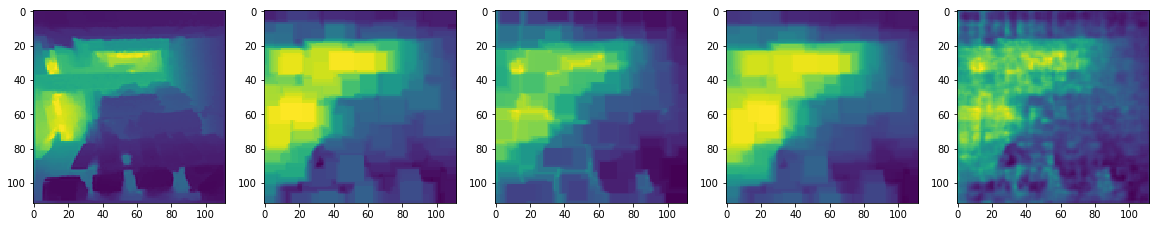

In [175]:
i = 89
imgg = X_train[i]
plt.rcParams['figure.figsize'] = [20, 20]
plt.figure(1)
plt.subplot(151)
plt.imshow(y_train[i][:,:,0])

plt.subplot(152)
iii =get_out(imgg)
iiii1 = morph_open(iii)
plt.imshow(iiii1)

plt.subplot(153)
iiii2 = morph_close(iii)
plt.imshow(iiii2)

plt.subplot(154)
iiii = (iiii1 + iiii2)/2
iiii = morph_open(iiii)
plt.imshow(iiii)

plt.subplot(155)
plt.imshow(iii)

plt.show()



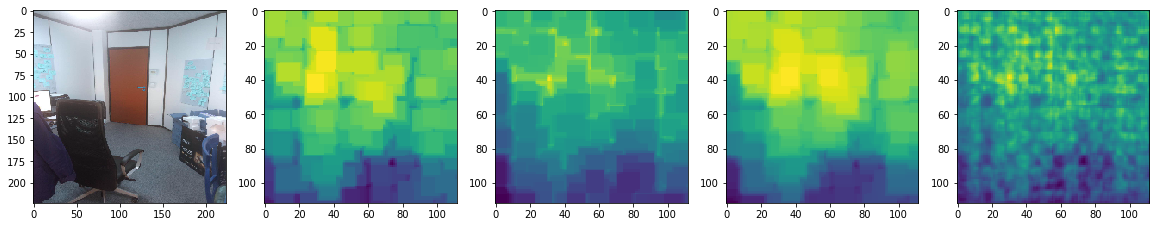

In [149]:
img20 = cv.imread('cv/t1.jpg')
img20 = cv.resize(img20, (224, 224))

plt.figure(1)
plt.subplot(151)
plt.imshow(img20)

plt.subplot(152)
iii =get_out(img20,True)
iiii1 = morph_open(iii)
plt.imshow(iiii1.T)


plt.subplot(153)
iiii2 = morph_close(iii)
plt.imshow(iiii2.T)

plt.subplot(154)
iiii = (iiii1 + iiii2)/2
iiii = morph_open(iiii)
plt.imshow(iiii.T)

plt.subplot(155)
plt.imshow(iii.T)

plt.show()


In [152]:
import utils

In [177]:
#img20 = cv.imread('cv/t1.jpg')
i = 100
img20 = X_train[i]
imgrgb = cv.resize(img20, (112, 112))
iii =  get_out(img20,True)
iiii1 = morph_open(iii)
iiii2 = morph_close(iii)
iiii = (iiii1 + iiii2)/2
imgdep = morph_open(iiii)

T_eye = np.eye(3,4)
mtx = np.eye(3)
res1 = utils.vert(imgrgb, imgdep, T_eye,mtx,inv = False)
utils.write_ply('out.ply', res1)
print('%s saved' % 'out1.ply')

out1.ply saved


## watershed example

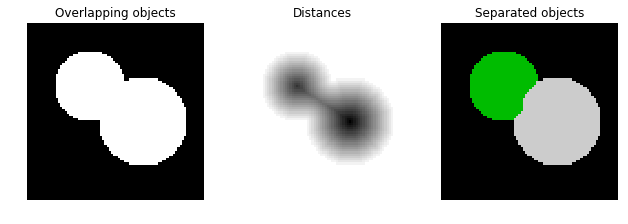

In [117]:
# Generate an initial image with two overlapping circles
x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
mask_circle1 = (x - x1)**2 + (y - y1)**2 < r1**2
mask_circle2 = (x - x2)**2 + (y - y2)**2 < r2**2
image = np.logical_or(mask_circle1, mask_circle2)

# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
                            labels=image)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral, interpolation='nearest')
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

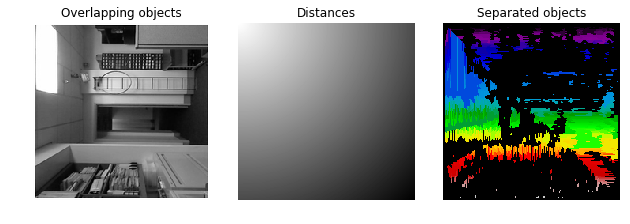

In [128]:
i = 16
image = X_train[i]
image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

distance = ndi.distance_transform_edt(image)
#distance = get_out(X_train[i])
#distance = cv.resize(distance, (224, 224))
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
                            labels=image)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral, interpolation='nearest')
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

## save model as image

In [41]:
# get the model as figure
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
from keras.utils import plot_model
plot_model(model, to_file='modelres.png')

## save model to yaml

In [ ]:
# serialize model to YAML
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 
# later...
 
# load YAML and create model
yaml_file = open('model.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))